In [74]:
import facenet
import os
import fnmatch
import numpy as np
from PIL import Image
from keras_facenet import FaceNet
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth
import os, glob
import cv2
import matplotlib.pyplot as plt

In [75]:
def load_faces(dir):
    faces = []
    for filename in os.listdir(dir):
        faces.append(np.asarray(Image.open(dir + filename)))
    return faces

In [76]:
dir = 'data/train_all/'
dir_val = 'data/validation_all/'
filenames = [filename for filename in os.listdir(dir)]
faces_train = load_faces(dir)
faces_val = load_faces(dir_val)
mean_shift_model = FaceNet()
embeddings_train = mean_shift_model.embeddings(faces_train)
embeddings_val = mean_shift_model.embeddings(faces_val)
# detections = [model.extract(face, threshold=0.95) for face in faces]  #no need to detect faces since the images are already cropped
# np.save('embeddings_train.npy', embeddings_train)
# np.save('embeddings_val.npy', embeddings_val)

16/16 [==============================] - 3s 212ms/step


In [77]:
# embeddings_train = np.load('embeddings_train.npy')
# embeddings_val = np.load('embeddings_val.npy')
pca = PCA(n_components=2)
X_train = pca.fit_transform(embeddings_train)
X_val = pca.fit_transform(embeddings_val)
bandwidth = estimate_bandwidth(X_train, quantile=0.0855, n_samples=1197)
mean_shift_model = MeanShift(bandwidth=bandwidth)
mean_shift_model.fit(X_train)

MeanShift(bandwidth=0.15333303643983434)

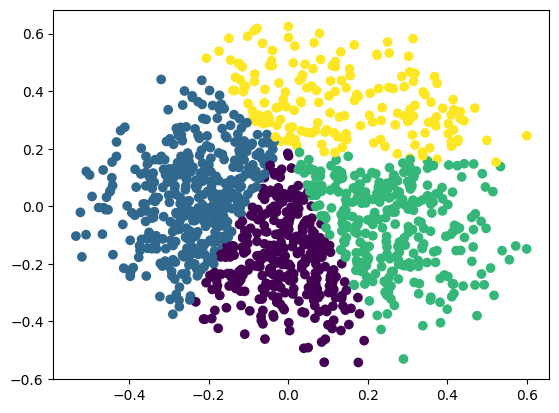

In [78]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=mean_shift_model.predict(X_train), cmap="viridis")
plt.show()

Clipping cluster size from 322 to 30


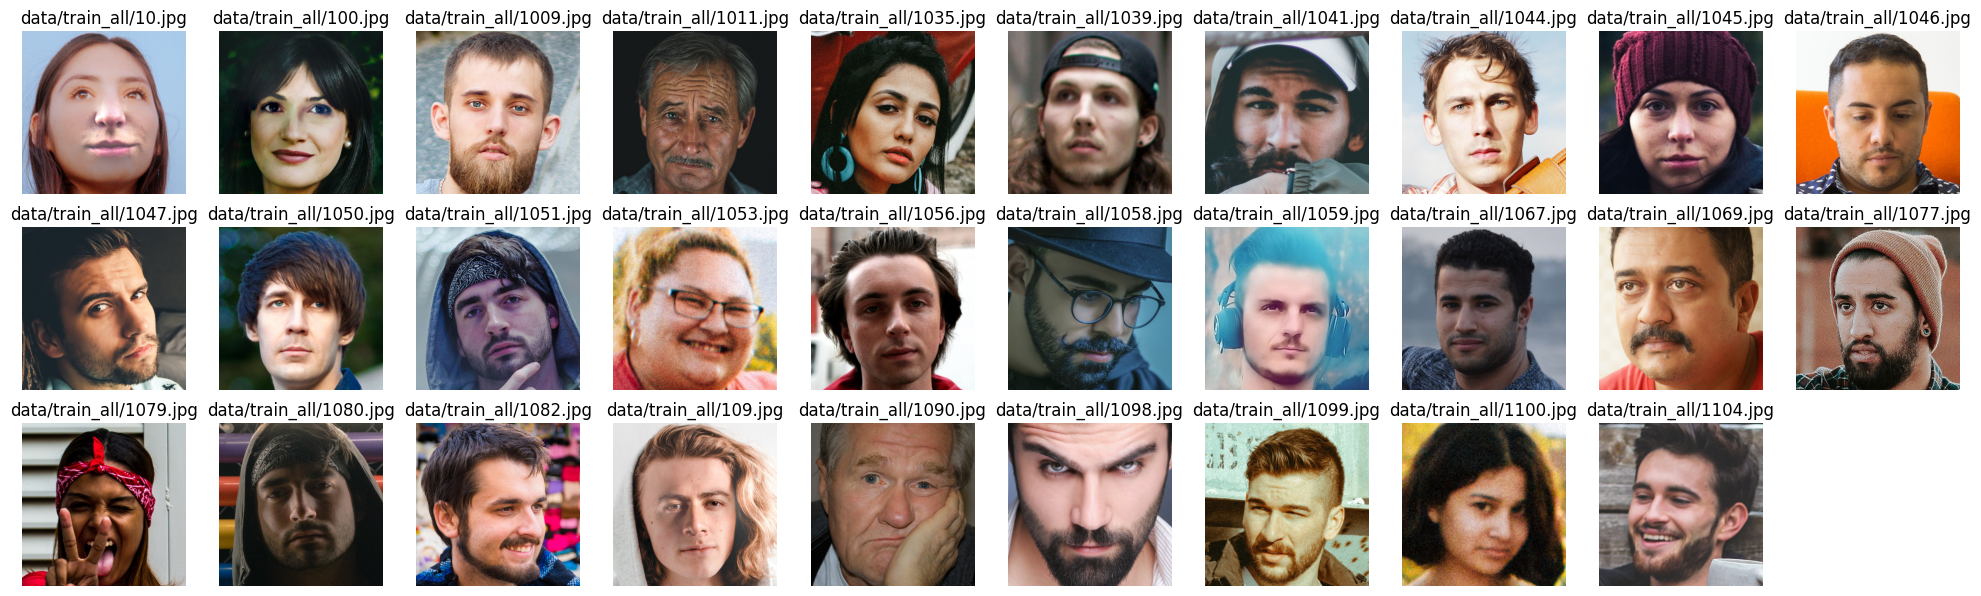

In [80]:
filepaths_train = [dir + filename for filename in os.listdir(dir)]
filepaths_val = [dir_val + filename for filename in os.listdir(dir_val)] #filepaths_train mean_shift_model.labels_
def get_groups(filepaths, labels):
    groups = {}
    for file, cluster in zip(filepaths, labels):
        if cluster not in groups.keys():
            groups[cluster] = []
            groups[cluster].append(file)
        else:
            groups[cluster].append(file)
    return groups

groups_train = get_groups(filepaths_train, mean_shift_model.labels_)
groups_val = get_groups(filepaths_val, mean_shift_model.predict(X_val))

def view_cluster(cluster, groups):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = Image.open(file)
        img = np.array(img)
        plt.imshow(img)
        plt.title(file)
        plt.axis('off')

view_cluster(0, groups_train)

Clipping cluster size from 399 to 30


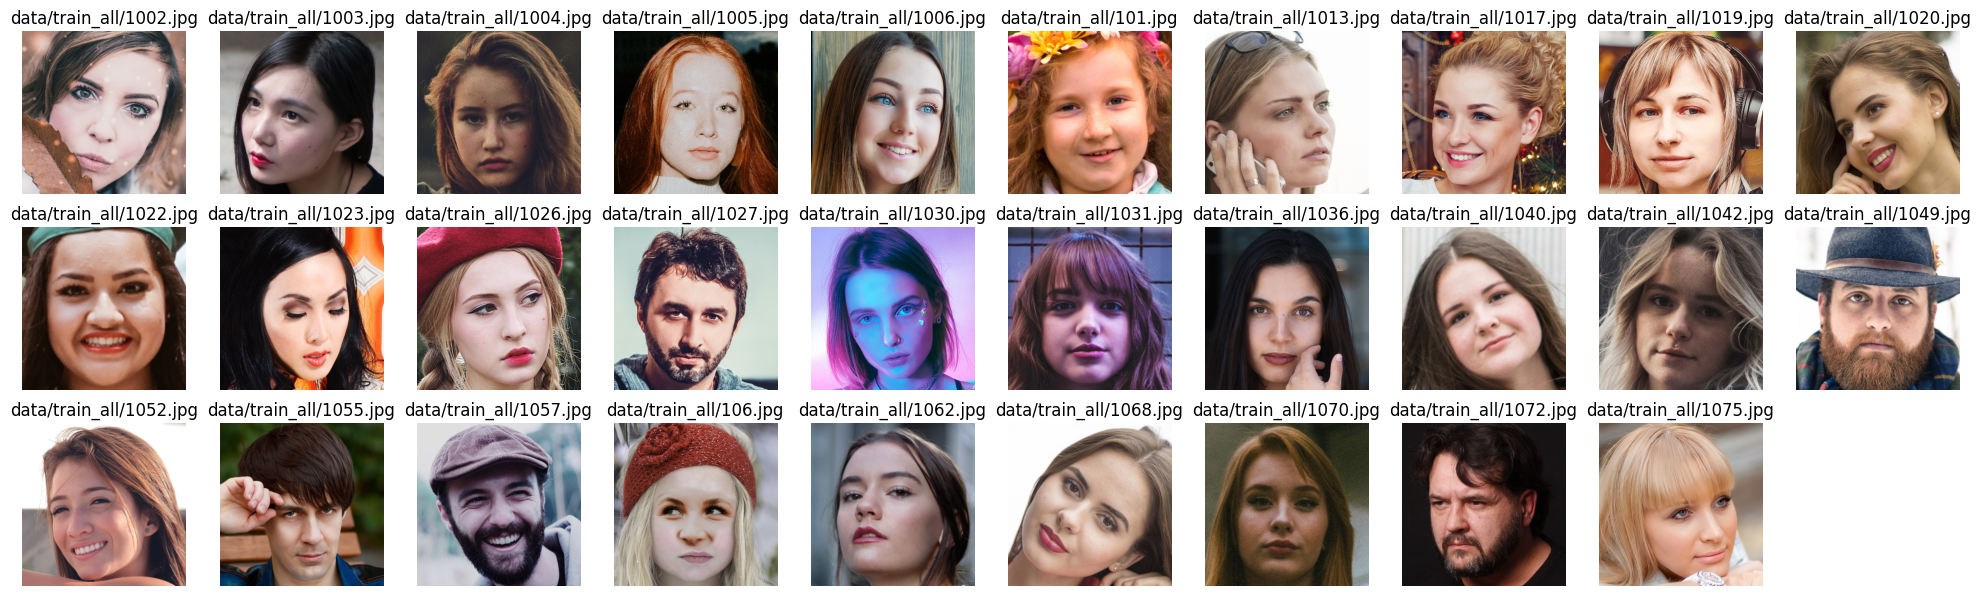

In [89]:
view_cluster(1, groups_train)

Clipping cluster size from 302 to 30


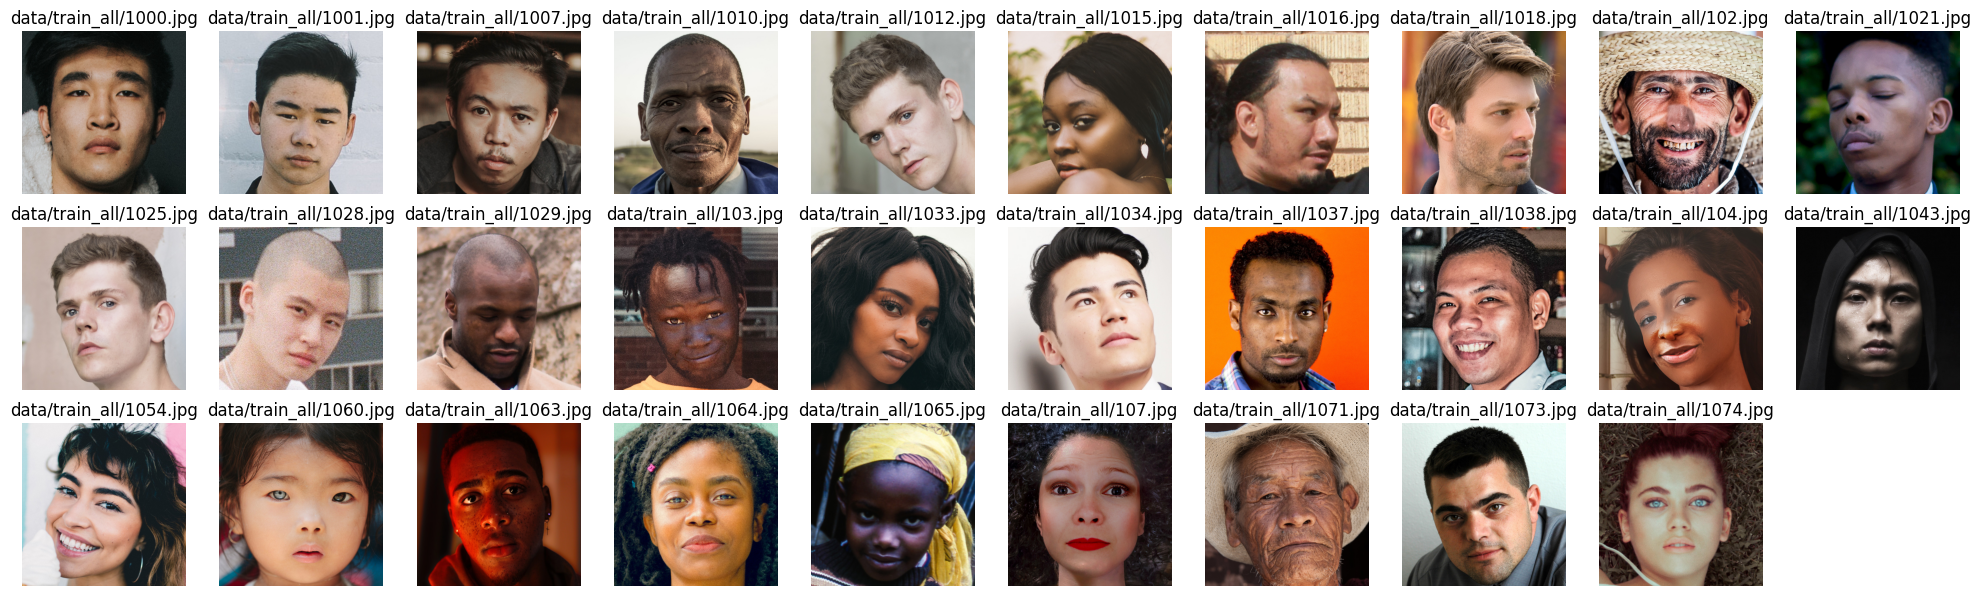

In [90]:
view_cluster(2, groups_train)

Clipping cluster size from 174 to 30


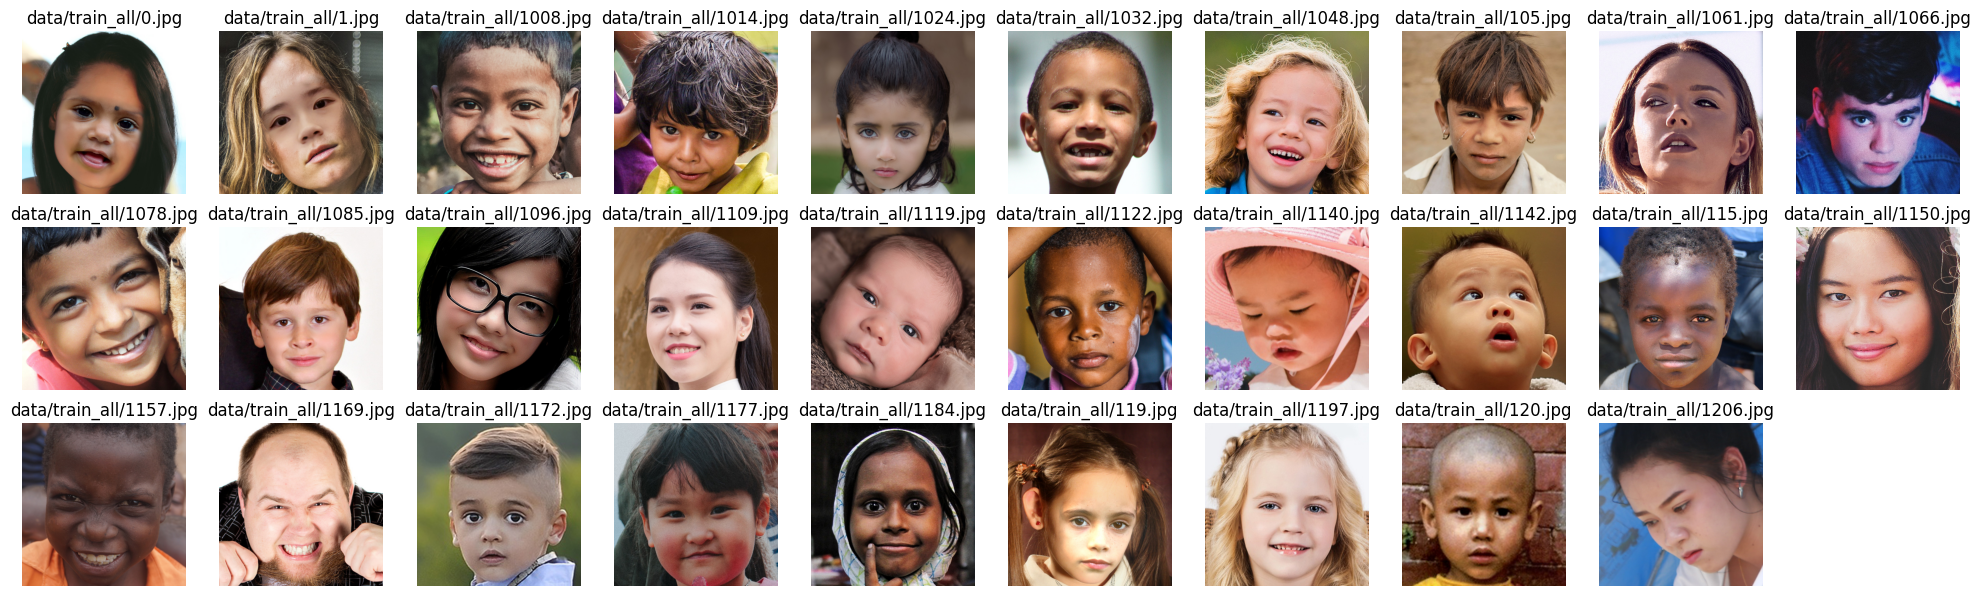

In [91]:
view_cluster(3, groups_train)

In [88]:
ground_truth_map_train = {}
for filename in os.listdir('data/train/real/'):
    ground_truth_map_train[dir + filename] = '0'
for filename in os.listdir('data/train/fake/'):
    ground_truth_map_train[dir + filename] = '1'

ground_truth_map_val = {}
for filename in os.listdir('data/Validation/real/'):
    ground_truth_map_val[dir_val + filename] = '0'
for filename in os.listdir('data/Validation/fake/'):
    ground_truth_map_val[dir_val + filename] = '1'

def get_predictions(groups): 
    preds = {}
    for idx in range(len(groups)):
        for filename in groups[idx]:
            if idx == 0:
                preds[filename] = 1  #first cluster seems to be composed of fake men
            elif idx == 1:
                preds[filename] = 0  #real women
            elif idx == 2:
                preds[filename] = 0  #real men
            else:
                preds[filename] = 1  #fake women/children
    return preds

preds_train = get_predictions(groups_train)
preds_val = get_predictions(groups_val)

accuracy_train = [int(ground_truth_map_train[dir + filename]) == int(preds_train[dir + filename]) for filename in os.listdir(dir)]
accuracy_val = [int(ground_truth_map_val[dir_val + filename]) == int(preds_val[dir_val + filename]) for filename in os.listdir(dir_val)]
print(f'Train accuracy: {np.mean(accuracy_train)}')
print(f'Validation accuracy: {np.mean(accuracy_val)}')

Train accuracy: 0.5355054302422724
Validation accuracy: 0.513671875
